In [1]:
import numpy as np
import pandas as pd
import glob
from natsort import natsorted, ns
import cv2
import dlib
import os
import random
from PIL import Image
from shutil import copyfile

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from scipy.spatial import distance
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import math
from imutils import face_utils


In [ ]:
# Create list of image names and corresponding gender classifications
image_dic = pd.read_excel('../Datasets/labels_B.xlsx')
image_dic = image_dic[['file_name', 'face_shape']] # Choose columns which are of importance
df = pd.DataFrame(image_dic)
df.to_excel('../Datasets/source_shape_B1/labels_B1.xlsx',index=False)

In [ ]:
# Separate different eye colours and corresponding labels into separate folders

# shape0 = 0
# shape1 = 1
# shape2 = 2
# shape3 = 3
# shape4 = 4

source_eye_color = pd.read_excel('../Datasets/source_shape_B1/labels_B1.xlsx')
source_images_file_paths = glob.glob ("../Datasets/source_images_B1/*.png") #find all paths which match the given path
source_images_file_paths = natsorted(source_images_file_paths) #sort the list of file names such that the image list will be in the correct order

shape0_directory = "../Datasets/sorted_sets_B1/shape0/"
shape1_directory = "../Datasets/sorted_sets_B1/shape1/"
shape2_directory = "../Datasets/sorted_sets_B1/shape2/"
shape3_directory = "../Datasets/sorted_sets_B1/shape3/"
shape4_directory = "../Datasets/sorted_sets_B1/shape4/"

for file_path in source_images_file_paths:
    image = cv2.imread(file_path, cv2.COLOR_RGB2BGR) #read the image
    image_name = os.path.basename(file_path)
    image_label = source_eye_color[source_eye_color['file_name']==image_name]['face_shape'].iloc[0]
    if(image_label == 0):
        directory = ''.join([shape0_directory,os.path.basename(image_name)])
        cv2.imwrite(directory, image)
    elif(image_label == 1):
        directory = ''.join([shape1_directory,os.path.basename(image_name)])
        cv2.imwrite(directory, image)
    elif(image_label == 2):
        directory = ''.join([shape2_directory,os.path.basename(image_name)])
        cv2.imwrite(directory, image)
    elif(image_label == 3):
        directory = ''.join([shape3_directory,os.path.basename(image_name)])
        cv2.imwrite(directory, image)
    elif(image_label == 4):
        directory = ''.join([shape4_directory,os.path.basename(image_name)])
        cv2.imwrite(directory, image)
    else:
        print("no label")

In [2]:
face_shapes = ["shape0", "shape1", "shape2","shape3","shape4"] #Define shapes

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") #Or set this to whatever you named the downloaded file

def euclid_distance(p1,p2):
    return distance.euclidean(p1, p2)

def midpoint(p1, p2):
    return [(p1[0]+p2[0])/2, (p1[1]+p2[1])/2]

def get_files(shape): #Define function to get file list, randomly shuffle it and split 80/20
    files = glob.glob("../Datasets/sorted_sets_B1/%s/*.png" %shape)
    return files

def get_landmarks(image):
    detections = detector(image, 1)
    landmarks_vectorised = []
    for k,d in enumerate(detections): #For all detected face instances individually
        shape = predictor(image, d) #Draw Facial Landmarks with the predictor class
        shape = face_utils.shape_to_np(shape)
        
        forehead = euclid_distance(shape[19], shape[24])
        cheekbones = euclid_distance(shape[36], shape[45])
        jawline = euclid_distance(shape[0], shape[16])
        midpoint_eyebrows = midpoint(shape[19], shape[24])
        face_lenght = euclid_distance(midpoint_eyebrows, shape[8])
                
        items = list(face_utils.FACIAL_LANDMARKS_IDXS.items())
        name, (i,j) = items[7] #the 7th item in the FACIAL_LANDMARKS_IDXS is the jaw line        
        landmarks_vectorised.append(forehead)
        landmarks_vectorised.append(cheekbones)
        landmarks_vectorised.append(jawline)
        landmarks_vectorised.append(face_lenght)
        landmarks_vectorised = np.asarray(landmarks_vectorised)
        landmarks_vectorised = np.append(shape[i:j], landmarks_vectorised)
        
    if len(detections) < 1:
        return []
    return landmarks_vectorised

def make_sets():
    input_images = []
    labels = []
    for shape in face_shapes:
        print(" working on %s" %shape)
        files = get_files(shape)
        filenumber = 0
        #Append data to training and prediction list, and generate labels 0-1
        for item in files:
            image = cv2.imread(item) #open image
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert to grayscale
            landmarks_vectorised = get_landmarks(gray)
            if (landmarks_vectorised != []):
                cv2.imwrite("../Datasets/B1_dataset/%s/%s.jpg" %(shape, filenumber), image) #Write image - don't need to worry about keeping track of labels associated because already sorted
                input_images.append(landmarks_vectorised) #append image array to training data list
                labels.append(face_shapes.index(shape))
                filenumber += 1 #Increment image number                
    training_data, prediction_data, training_labels, prediction_labels = train_test_split(input_images,labels)
    
    return training_data, training_labels, prediction_data, prediction_labels,  input_images, labels

print("Making sets")
training_data, training_labels, prediction_data, prediction_labels, image_inputs, image_labels = make_sets()     

Making sets
 working on shape0


C:\Users\herrn\Documents\University\Anaconda\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


 working on shape1
 working on shape2
 working on shape3
 working on shape4


In [3]:
training_data = np.asarray(training_data)
training_labels = np.asarray(training_labels)
prediction_data = np.asarray(prediction_data)
prediction_labels = np.asarray(prediction_labels)


image_inputs = np.asarray(image_inputs)
image_labels = np.asarray(image_labels)

print(training_data.shape)
print(training_labels.shape)
print(prediction_data.shape)
print(prediction_labels.shape)

image_inputs_rs = np.asarray(image_inputs) #image_inputs.reshape(image_inputs.shape[0], image_inputs.shape[1])#*image_inputs.shape[2])#*image_inputs.shape[3])

print(image_inputs_rs.shape)
print(image_labels.shape)

(6067, 38)
(6067,)
(2023, 38)
(2023,)
(8090, 38)
(8090,)


In [4]:
# Normalise data for clustering
scaler = StandardScaler() 
input_features_scaled = scaler.fit_transform(image_inputs_rs)
df_input_features_scaled = pd.DataFrame(input_features_scaled) 
print(df_input_features_scaled.head()) 

         0         1         2         3         4         5         6   \
0  0.721943  0.590865  0.246466  0.458382 -0.187064  0.393150  0.008464   
1 -0.183059 -0.871002 -0.345082 -1.011555 -0.780688 -1.167665 -0.992602   
2 -0.364059 -0.348907 -0.345082 -0.333122 -0.384939 -0.447289 -0.191749   
3 -0.545059  0.068769 -0.739447  0.119166 -0.978563  0.153024 -0.592176   
4 -0.545059  0.799703 -0.542265  0.797598 -0.384939  0.753338  0.208677   

         7         8         9   ...        28        29        30        31  \
0  0.248623  0.117285  0.206435  ... -1.101723  0.747794 -1.354565  0.935542   
1 -1.195367 -0.938855 -1.181907  ...  0.283134 -1.009635  0.215136 -0.869122   
2 -0.473372  0.117285 -0.603431  ... -0.063080  0.161985  0.215136  0.146002   
3  0.128290  0.117285 -0.024955  ...  0.456241  0.044823  0.040725 -0.079581   
4  0.489287  1.173425  0.206435  ...  0.456241  0.630632  0.389547  0.709959   

         32        33        34        35        36        37  
0 -1

In [5]:
dataframe = pd.DataFrame(input_features_scaled)
dataframe["label"] = image_labels

shape0_df = dataframe[dataframe['label'] == 0]
shape1_df = dataframe[dataframe['label'] == 1]
shape2_df = dataframe[dataframe['label'] == 2]
shape3_df = dataframe[dataframe['label'] == 3]
shape4_df = dataframe[dataframe['label'] == 4]

shape0_inputs = shape0_df.drop(['label'], axis=1).values
shape0_labels = shape0_df.filter(['label'], axis=1).values

shape1_inputs = shape1_df.drop(['label'], axis=1).values
shape1_labels = shape1_df.filter(['label'], axis=1).values

shape2_inputs = shape2_df.drop(['label'], axis=1).values
shape2_labels = shape2_df.filter(['label'], axis=1).values

shape3_inputs = shape3_df.drop(['label'], axis=1).values
shape3_labels = shape3_df.filter(['label'], axis=1).values

shape4_inputs = shape4_df.drop(['label'], axis=1).values
shape4_labels = shape4_df.filter(['label'], axis=1).values

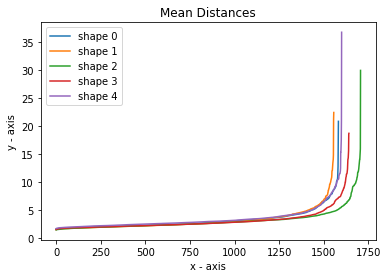

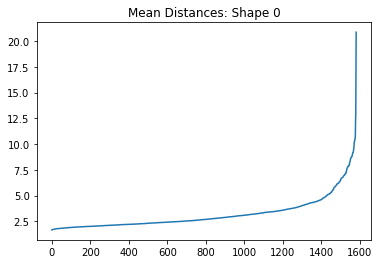

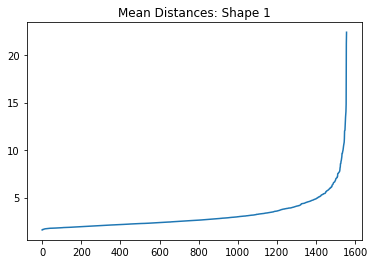

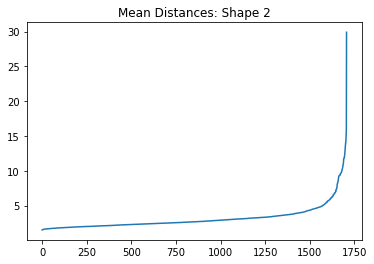

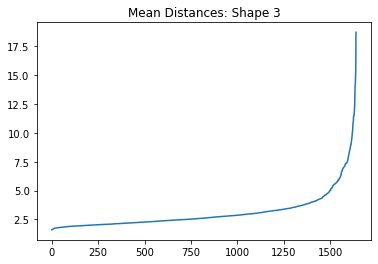

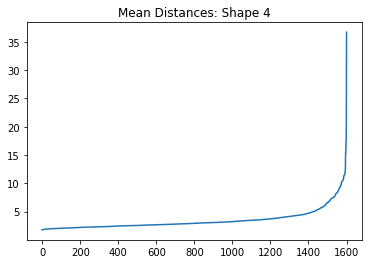

In [6]:
neigh = NearestNeighbors(n_neighbors=50)

shape0_nbrs = neigh.fit(shape0_inputs)
shape0_distances, shape0_indices = shape0_nbrs.kneighbors(shape0_inputs)
shape0_distances = shape0_distances[:,1:]
shape0_distances_mean = np.mean(shape0_distances, axis=1)
shape0_distances_mean = np.sort(shape0_distances_mean, axis=0)

shape1_nbrs = neigh.fit(shape1_inputs)
shape1_distances, shape1_indices = shape1_nbrs.kneighbors(shape1_inputs)
shape1_distances = shape1_distances[:,1:]
shape1_distances_mean = np.mean(shape1_distances, axis=1)
shape1_distances_mean = np.sort(shape1_distances_mean, axis=0)

shape2_nbrs = neigh.fit(shape2_inputs)
shape2_distances, shape2_indices = shape2_nbrs.kneighbors(shape2_inputs)
shape2_distances = shape2_distances[:,1:]
shape2_distances_mean = np.mean(shape2_distances, axis=1)
shape2_distances_mean = np.sort(shape2_distances_mean, axis=0)

shape3_nbrs = neigh.fit(shape3_inputs)
shape3_distances, shape3_indices = shape3_nbrs.kneighbors(shape3_inputs)
shape3_distances = shape3_distances[:,1:]
shape3_distances_mean = np.mean(shape3_distances, axis=1)
shape3_distances_mean = np.sort(shape3_distances_mean, axis=0)

shape4_nbrs = neigh.fit(shape4_inputs)
shape4_distances, shape4_indices = shape4_nbrs.kneighbors(shape4_inputs)
shape4_distances = shape4_distances[:,1:]
shape4_distances_mean = np.mean(shape4_distances, axis=1)
shape4_distances_mean = np.sort(shape4_distances_mean, axis=0)

plt.plot(shape0_distances_mean, label = "shape 0")
plt.plot(shape1_distances_mean, label = "shape 1")
plt.plot(shape2_distances_mean, label = "shape 2")
plt.plot(shape3_distances_mean, label = "shape 3")
plt.plot(shape4_distances_mean, label = "shape 4")
plt.xlabel('x - axis')
# Set the y axis label of the current axis.
plt.ylabel('y - axis')
# Set a title of the current axes.
plt.title('Mean Distances')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.savefig('../plots_B1/distances_mean.png')
plt.show()

plt.title("Mean Distances: Shape 0")
plt.plot(shape0_distances_mean)
#plt.savefig('../plots_B1/shape0_distances_mean.png')
plt.show()
plt.title("Mean Distances: Shape 1")
plt.plot(shape1_distances_mean)
#plt.savefig('../plots_B1/shape1_distances_mean.png')
plt.show()
plt.title("Mean Distances: Shape 2")
plt.plot(shape2_distances_mean)
#plt.savefig('../plots_B1/shape2_distances_mean.png')
plt.show()
plt.title("Mean Distances: Shape 3")
plt.plot(shape3_distances_mean)
#plt.savefig('../plots_B1/shape3_distances_mean.png')
plt.show()
plt.title("Mean Distances: Shape 4")
plt.plot(shape4_distances_mean)
#plt.savefig('../plots_B1/shape4_distances_mean.png')
plt.show()

In [7]:
# DBSCAN for outlier detection and removal

shape0_dbscan = DBSCAN(eps = 5, min_samples = 38*3).fit(shape0_inputs) 
shape0_outlier_labels = shape0_dbscan.labels_

shape1_dbscan = DBSCAN(eps = 5, min_samples = 38*3).fit(shape1_inputs) 
shape1_outlier_labels = shape1_dbscan.labels_

shape2_dbscan = DBSCAN(eps = 5, min_samples = 38*3).fit(shape2_inputs) 
shape2_outlier_labels = shape2_dbscan.labels_

shape3_dbscan = DBSCAN(eps = 5, min_samples = 38*3).fit(shape3_inputs) 
shape3_outlier_labels = shape3_dbscan.labels_

shape4_dbscan = DBSCAN(eps = 5, min_samples = 38*3).fit(shape4_inputs) 
shape4_outlier_labels = shape4_dbscan.labels_

print(np.sum(shape0_outlier_labels == -1))
print(np.sum(shape1_outlier_labels == -1))
print(np.sum(shape2_outlier_labels == -1))
print(np.sum(shape3_outlier_labels == -1))
print(np.sum(shape4_outlier_labels == -1))

print(np.sum(shape0_outlier_labels == 0))
print(np.sum(shape1_outlier_labels == 0))
print(np.sum(shape2_outlier_labels == 0))
print(np.sum(shape3_outlier_labels == 0))
print(np.sum(shape4_outlier_labels == 0))

shape0_non_outlier_idx = np.where(shape0_outlier_labels == 0)[0]
shape1_non_outlier_idx = np.where(shape1_outlier_labels == 0)[0]
shape2_non_outlier_idx = np.where(shape2_outlier_labels == 0)[0]
shape3_non_outlier_idx = np.where(shape3_outlier_labels == 0)[0]
shape4_non_outlier_idx = np.where(shape4_outlier_labels == 0)[0]

new_shape0_inputs_dbscan = np.asarray([shape0_inputs[i] for i in shape0_non_outlier_idx])
new_shape0_labels_dbscan = np.asarray([shape0_labels[i] for i in shape0_non_outlier_idx])

new_shape1_inputs_dbscan = np.asarray([shape1_inputs[i] for i in shape1_non_outlier_idx])
new_shape1_labels_dbscan = np.asarray([shape1_labels[i] for i in shape1_non_outlier_idx])

new_shape2_inputs_dbscan = np.asarray([shape2_inputs[i] for i in shape2_non_outlier_idx])
new_shape2_labels_dbscan = np.asarray([shape2_labels[i] for i in shape2_non_outlier_idx])

new_shape3_inputs_dbscan = np.asarray([shape3_inputs[i] for i in shape3_non_outlier_idx])
new_shape3_labels_dbscan = np.asarray([shape3_labels[i] for i in shape3_non_outlier_idx])

new_shape4_inputs_dbscan = np.asarray([shape4_inputs[i] for i in shape4_non_outlier_idx])
new_shape4_labels_dbscan = np.asarray([shape4_labels[i] for i in shape4_non_outlier_idx])

print(new_shape0_inputs_dbscan.shape)
print(new_shape1_inputs_dbscan.shape)
print(new_shape2_inputs_dbscan.shape)
print(new_shape3_inputs_dbscan.shape)
print(new_shape4_inputs_dbscan.shape)

new_image_inputs = np.concatenate((new_shape0_inputs_dbscan, new_shape1_inputs_dbscan, new_shape2_inputs_dbscan, new_shape3_inputs_dbscan, new_shape4_inputs_dbscan))
new_image_labels = np.concatenate((new_shape0_labels_dbscan, new_shape1_labels_dbscan, new_shape2_labels_dbscan, new_shape3_labels_dbscan, new_shape4_labels_dbscan))

print(new_image_inputs.shape)
print(new_image_labels.shape)

new_training_data, new_prediction_data, new_training_labels, new_prediction_labels = train_test_split(new_image_inputs,new_image_labels)

print("Shape of training and testing data")
print(new_training_data.shape)
print(new_training_labels.shape)
print(new_prediction_data.shape)
print(new_prediction_labels.shape)

114
102
96
107
123
1469
1455
1611
1535
1478
(1469, 38)
(1455, 38)
(1611, 38)
(1535, 38)
(1478, 38)
(7548, 38)
(7548, 1)
Shape of training and testing data
(5661, 38)
(5661, 1)
(1887, 38)
(1887, 1)


In [ ]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10,100,1000]
    gammas = [0.001, 0.01, 0.1, 1,10,'scale']
    decision_function_shapes = ['OVO', 'OVA']
    param_grid = {'C': Cs, 'gamma' : gammas, 'decision_function_shape': decision_function_shapes}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    best_params = grid_search.best_params_
    mean_CV_score = grid_search.cv_results_['mean_test_score']
    return best_params, mean_CV_score

best_params, mean_results = svc_param_selection(new_training_data, new_training_labels.ravel(),5)

In [ ]:
print(best_params)
print(mean_results)

In [10]:
#train_data, predict_data, train_labels, predict_labels = train_test_split(image_inputs_rs,image_labels)

print("training SVM") #train SVM
clf = SVC(kernel='rbf', C = 100, gamma = 0.001, decision_function_shape = 'OVO') #Set the classifier as a support vector machine
clf.fit(new_training_data, new_training_labels.ravel())
print("getting accuracy") #Use score() function to get accuracy
pred_lin = clf.score(new_prediction_data, new_prediction_labels.ravel())
print ("Accuracy: ", pred_lin)

training SVM
getting accuracy
Accuracy:  0.7927927927927928


In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.title(title)
    plt.ylim(ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    print(train_sizes)
    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    plt.legend(loc="best")

    return plt


X, y = new_training_data, new_training_labels.ravel()

title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001, C = 5000, decision function shape = OVO$)"

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# SVC is more expensive so we do a lower number of CV iterations:
kf = KFold(n_splits=5)

c= 5000
gamma = 0.001
method = 'OVO'

estimator = SVC(kernel='rbf',C = c , gamma = gamma, decision_function_shape = method)
plt = plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01),
                    cv=kf, n_jobs=4)
plt.savefig('../plots_B1/5000_learningcurve_B1.png')
plt.show()

In [19]:
# test model

def sort_data(labels_dir):
    # Create list of image names and corresponding gender classifications
    image_dic = pd.read_excel(labels_dir)
    image_dic = image_dic[['file_name', 'face_shape']] # Choose columns which are of importance
    df = pd.DataFrame(image_dic)
    df.to_excel('../Datasets/test_source_shape_B1/test_labels_B1.xlsx',index=False)

    source_eye_color = pd.read_excel('../Datasets/test_source_shape_B1/test_labels_B1.xlsx')
    source_images_file_paths = glob.glob ("../Datasets/test_source_images_B1/*.png") #find all paths which match the given path
    source_images_file_paths = natsorted(source_images_file_paths) #sort the list of file names such that the image list will be in the correct order

    shape0_directory = "../Datasets/test_sorted_sets_B1/shape0/"
    shape1_directory = "../Datasets/test_sorted_sets_B1/shape1/"
    shape2_directory = "../Datasets/test_sorted_sets_B1/shape2/"
    shape3_directory = "../Datasets/test_sorted_sets_B1/shape3/"
    shape4_directory = "../Datasets/test_sorted_sets_B1/shape4/"

    for file_path in source_images_file_paths:
        image = cv2.imread(file_path, cv2.COLOR_RGB2BGR) #read the image
        image_name = os.path.basename(file_path)
        image_label = source_eye_color[source_eye_color['file_name']==image_name]['face_shape'].iloc[0]
        if(image_label == 0):
            directory = ''.join([shape0_directory,os.path.basename(image_name)])
            cv2.imwrite(directory, image)
        elif(image_label == 1):
            directory = ''.join([shape1_directory,os.path.basename(image_name)])
            cv2.imwrite(directory, image)
        elif(image_label == 2):
            directory = ''.join([shape2_directory,os.path.basename(image_name)])
            cv2.imwrite(directory, image)
        elif(image_label == 3):
            directory = ''.join([shape3_directory,os.path.basename(image_name)])
            cv2.imwrite(directory, image)
        elif(image_label == 4):
            directory = ''.join([shape4_directory,os.path.basename(image_name)])
            cv2.imwrite(directory, image)
        else:
            print("no label")
            
def get_test_files(shape): #Define function to get file list, randomly shuffle it and split 80/20
    files = glob.glob("../Datasets/test_sorted_sets_B1/%s/*.png" %shape)
    return files

def get_test_landmarks(image):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") #Or set this to whatever you named the downloaded file
    detections = detector(image, 1)
    landmarks_vectorised = []
    for k,d in enumerate(detections): #For all detected face instances individually
        shape = predictor(image, d) #Draw Facial Landmarks with the predictor class
        shape = face_utils.shape_to_np(shape)
        
        forehead = euclid_distance(shape[19], shape[24])
        cheekbones = euclid_distance(shape[36], shape[45])
        jawline = euclid_distance(shape[0], shape[16])
        midpoint_eyebrows = midpoint(shape[19], shape[24])
        face_lenght = euclid_distance(midpoint_eyebrows, shape[8])
                
        items = list(face_utils.FACIAL_LANDMARKS_IDXS.items())
        name, (i,j) = items[7] #the 7th item in the FACIAL_LANDMARKS_IDXS is the jaw line        
        landmarks_vectorised.append(forehead)
        landmarks_vectorised.append(cheekbones)
        landmarks_vectorised.append(jawline)
        landmarks_vectorised.append(face_lenght)
        landmarks_vectorised = np.asarray(landmarks_vectorised)
        landmarks_vectorised = np.append(shape[i:j], landmarks_vectorised)
        
    if len(detections) < 1:
        return []
    return landmarks_vectorised

def make_test_sets():
    input_images = []
    labels = []
    for shape in face_shapes:
        print(" working on %s" %shape)
        files = get_test_files(shape)
        filenumber = 0
        #Append data to training and prediction list, and generate labels 0-1
        for item in files:
            image = cv2.imread(item) #open image
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert to grayscale
            landmarks_vectorised = get_test_landmarks(gray)
            if (landmarks_vectorised != []):
                cv2.imwrite("../Datasets/test_B1_dataset/%s/%s.jpg" %(shape, filenumber), image) #Write image - don't need to worry about keeping track of labels associated because already sorted
                input_images.append(landmarks_vectorised) #append image array to training data list
                labels.append(face_shapes.index(shape))
                filenumber += 1 #Increment image number                
    training_data, prediction_data, training_labels, prediction_labels = train_test_split(input_images,labels)
    
    return training_data, training_labels, prediction_data, prediction_labels, input_images, labels

def outlier_removal(image_inputs,image_labels):
    
    image_inputs = np.asarray(image_inputs)
    image_labels = np.asarray(image_labels)

    print(training_data.shape)
    print(training_labels.shape)
    print(prediction_data.shape)
    print(prediction_labels.shape)

    image_inputs_rs = np.asarray(image_inputs) #image_inputs.reshape(image_inputs.shape[0], image_inputs.shape[1])#*image_inputs.shape[2])#*image_inputs.shape[3])

    print(image_inputs_rs.shape)
    print(image_labels.shape)
    
    # Normalise data for clustering
    scaler = StandardScaler() 
    input_features_scaled = scaler.fit_transform(image_inputs_rs)
    df_input_features_scaled = pd.DataFrame(input_features_scaled) 
    print(df_input_features_scaled.head()) 
    
    dataframe = pd.DataFrame(input_features_scaled)
    dataframe["label"] = image_labels

    shape0_df = dataframe[dataframe['label'] == 0]
    shape1_df = dataframe[dataframe['label'] == 1]
    shape2_df = dataframe[dataframe['label'] == 2]
    shape3_df = dataframe[dataframe['label'] == 3]
    shape4_df = dataframe[dataframe['label'] == 4]

    shape0_inputs = shape0_df.drop(['label'], axis=1).values
    shape0_labels = shape0_df.filter(['label'], axis=1).values

    shape1_inputs = shape1_df.drop(['label'], axis=1).values
    shape1_labels = shape1_df.filter(['label'], axis=1).values

    shape2_inputs = shape2_df.drop(['label'], axis=1).values
    shape2_labels = shape2_df.filter(['label'], axis=1).values

    shape3_inputs = shape3_df.drop(['label'], axis=1).values
    shape3_labels = shape3_df.filter(['label'], axis=1).values

    shape4_inputs = shape4_df.drop(['label'], axis=1).values
    shape4_labels = shape4_df.filter(['label'], axis=1).values
    
    neigh = NearestNeighbors(n_neighbors=50)

    shape0_nbrs = neigh.fit(shape0_inputs)
    shape0_distances, shape0_indices = shape0_nbrs.kneighbors(shape0_inputs)
    shape0_distances = shape0_distances[:,1:]
    shape0_distances_mean = np.mean(shape0_distances, axis=1)
    shape0_distances_mean = np.sort(shape0_distances_mean, axis=0)

    shape1_nbrs = neigh.fit(shape1_inputs)
    shape1_distances, shape1_indices = shape1_nbrs.kneighbors(shape1_inputs)
    shape1_distances = shape1_distances[:,1:]
    shape1_distances_mean = np.mean(shape1_distances, axis=1)
    shape1_distances_mean = np.sort(shape1_distances_mean, axis=0)

    shape2_nbrs = neigh.fit(shape2_inputs)
    shape2_distances, shape2_indices = shape2_nbrs.kneighbors(shape2_inputs)
    shape2_distances = shape2_distances[:,1:]
    shape2_distances_mean = np.mean(shape2_distances, axis=1)
    shape2_distances_mean = np.sort(shape2_distances_mean, axis=0)

    shape3_nbrs = neigh.fit(shape3_inputs)
    shape3_distances, shape3_indices = shape3_nbrs.kneighbors(shape3_inputs)
    shape3_distances = shape3_distances[:,1:]
    shape3_distances_mean = np.mean(shape3_distances, axis=1)
    shape3_distances_mean = np.sort(shape3_distances_mean, axis=0)

    shape4_nbrs = neigh.fit(shape4_inputs)
    shape4_distances, shape4_indices = shape4_nbrs.kneighbors(shape4_inputs)
    shape4_distances = shape4_distances[:,1:]
    shape4_distances_mean = np.mean(shape4_distances, axis=1)
    shape4_distances_mean = np.sort(shape4_distances_mean, axis=0)
    
    # DBSCAN for outlier detection and removal

    shape0_dbscan = DBSCAN(eps = 5, min_samples = 38*3).fit(shape0_inputs) 
    shape0_outlier_labels = shape0_dbscan.labels_

    shape1_dbscan = DBSCAN(eps = 5, min_samples = 38*3).fit(shape1_inputs) 
    shape1_outlier_labels = shape1_dbscan.labels_

    shape2_dbscan = DBSCAN(eps = 5, min_samples = 38*3).fit(shape2_inputs) 
    shape2_outlier_labels = shape2_dbscan.labels_

    shape3_dbscan = DBSCAN(eps = 5, min_samples = 38*3).fit(shape3_inputs) 
    shape3_outlier_labels = shape3_dbscan.labels_

    shape4_dbscan = DBSCAN(eps = 5, min_samples = 38*3).fit(shape4_inputs) 
    shape4_outlier_labels = shape4_dbscan.labels_

    print(np.sum(shape0_outlier_labels == -1))
    print(np.sum(shape1_outlier_labels == -1))
    print(np.sum(shape2_outlier_labels == -1))
    print(np.sum(shape3_outlier_labels == -1))
    print(np.sum(shape4_outlier_labels == -1))

    print(np.sum(shape0_outlier_labels == 0))
    print(np.sum(shape1_outlier_labels == 0))
    print(np.sum(shape2_outlier_labels == 0))
    print(np.sum(shape3_outlier_labels == 0))
    print(np.sum(shape4_outlier_labels == 0))

    shape0_non_outlier_idx = np.where(shape0_outlier_labels == 0)[0]
    shape1_non_outlier_idx = np.where(shape1_outlier_labels == 0)[0]
    shape2_non_outlier_idx = np.where(shape2_outlier_labels == 0)[0]
    shape3_non_outlier_idx = np.where(shape3_outlier_labels == 0)[0]
    shape4_non_outlier_idx = np.where(shape4_outlier_labels == 0)[0]

    new_shape0_inputs_dbscan = np.asarray([shape0_inputs[i] for i in shape0_non_outlier_idx])
    new_shape0_labels_dbscan = np.asarray([shape0_labels[i] for i in shape0_non_outlier_idx])

    new_shape1_inputs_dbscan = np.asarray([shape1_inputs[i] for i in shape1_non_outlier_idx])
    new_shape1_labels_dbscan = np.asarray([shape1_labels[i] for i in shape1_non_outlier_idx])

    new_shape2_inputs_dbscan = np.asarray([shape2_inputs[i] for i in shape2_non_outlier_idx])
    new_shape2_labels_dbscan = np.asarray([shape2_labels[i] for i in shape2_non_outlier_idx])

    new_shape3_inputs_dbscan = np.asarray([shape3_inputs[i] for i in shape3_non_outlier_idx])
    new_shape3_labels_dbscan = np.asarray([shape3_labels[i] for i in shape3_non_outlier_idx])

    new_shape4_inputs_dbscan = np.asarray([shape4_inputs[i] for i in shape4_non_outlier_idx])
    new_shape4_labels_dbscan = np.asarray([shape4_labels[i] for i in shape4_non_outlier_idx])

    print(new_shape0_inputs_dbscan.shape)
    print(new_shape1_inputs_dbscan.shape)
    print(new_shape2_inputs_dbscan.shape)
    print(new_shape3_inputs_dbscan.shape)
    print(new_shape4_inputs_dbscan.shape)

    new_image_inputs = np.concatenate((new_shape0_inputs_dbscan, new_shape1_inputs_dbscan, new_shape2_inputs_dbscan, new_shape3_inputs_dbscan, new_shape4_inputs_dbscan))
    new_image_labels = np.concatenate((new_shape0_labels_dbscan, new_shape1_labels_dbscan, new_shape2_labels_dbscan, new_shape3_labels_dbscan, new_shape4_labels_dbscan))

    print(new_image_inputs.shape)
    print(new_image_labels.shape)
    print("Shape of training and testing data")

    new_training_data, new_prediction_data, new_training_labels, new_prediction_labels = train_test_split(new_image_inputs,new_image_labels)
    print(new_training_data.shape)
    print(new_training_labels.shape)
    print(new_prediction_data.shape)
    print(new_prediction_labels.shape)
    
    return new_training_data, new_prediction_data, new_training_labels, new_prediction_labels, new_image_inputs, new_image_labels




#main

face_shapes = ["shape0", "shape1", "shape2","shape3","shape4"] #Define shapes
test_dir = '../Datasets/test_labels_B.xlsx'
sort_data(test_dir)
print("Making sets")
_, _, _, _, test_image_inputs, test_image_labels = make_test_sets()
print("Removing Outliers")
_, _, _, _, test_image_inputs1, test_image_labels1 = outlier_removal(test_image_inputs, test_image_labels)



Making sets
 working on shape0


C:\Users\herrn\Documents\University\Anaconda\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


 working on shape1
 working on shape2
 working on shape3
 working on shape4
Removing Outliers
(6067, 38)
(6067,)
(2023, 38)
(2023,)
(2017, 38)
(2017,)
         0         1         2         3         4         5         6   \
0 -0.183197 -0.279276 -0.345886 -0.254537 -0.579776 -0.358589 -0.384971   
1 -0.891070 -0.702014 -0.731115 -0.595213 -0.965720 -0.597412 -1.161652   
2 -0.714102 -0.384960 -0.923730 -0.368096 -0.965720 -0.358589 -0.773311   
3 -1.245006  0.249147 -1.694190  0.426817 -2.123550  0.716112 -2.132503   
4  0.878611  1.517363  1.002419  1.221730  0.963998  0.716112  1.168391   

         7         8         9   ...        28        29        30        31  \
0 -0.382817 -0.081801 -0.622025  ...  0.469498 -0.571042  0.389711 -0.450961   
1 -0.500791 -0.487189 -0.734276  ...  1.181111 -1.037402  0.746924 -1.015011   
2 -0.382817 -0.487189 -0.509775  ...  0.469498 -0.221272  0.389711 -0.225341   
3  1.150849 -1.906048  1.398486  ...  1.536917  1.177807  1.282744  0.789950  

In [20]:
print("getting accuracy") #Use score() function to get accuracy
pred_lin = clf.score(test_image_inputs1, test_image_labels1.ravel())
print ("Accuracy: ", pred_lin)

getting accuracy
Accuracy:  0.8327740492170023
